In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('./rclootcouncil.tsv', sep='\t', header=0)

In [3]:
df['dt'] = pd.to_datetime(df.apply(lambda r: '{} {}'.format(r['date'], r['time']), axis=1))
df['kill_id'] = np.nan

In [4]:
raids = ['Castle Nathria', 'Sanctum of Domination']
difficulties = ['Normal', 'Heroic', 'Mythic']

In [6]:
# data post-loot-hotfix
sl_data = df[(df.dt >= pd.to_datetime('2021-02-16')) & df['instance'].isin(set(['Castle Nathria-Normal', 'Castle Nathria-Heroic', 'Castle Nathria-Mythic', 'Sanctum of Domination-Normal', 'Sanctum of Domination-Heroic', 'Sanctum of Domination-Mythic']))]

In [7]:
sl_data['dt'].head(1).iloc[0]

Timestamp('2021-07-22 20:43:18')

In [8]:
def kill_ids(loot, start_ix=0):
    loot = loot.sort_values('dt')
    loot['run_id'] = np.nan
    
    kill_id = start_ix
    run_id = start_ix
    previous = loot.head(1)[['instance', 'boss']]
    previous_dt = loot['dt'].head(1).iloc[0]
    for ix, row in loot.iterrows():
        if (row[['instance', 'boss']] != previous).any().any() or row['dt'] >= previous_dt + pd.to_timedelta('4 hours'):
            previous = row[['instance', 'boss']]
            if row['dt'] >= previous_dt + pd.to_timedelta('4 hours'):
                run_id += 1
            previous_dt = row['dt']
            kill_id += 1
        loot.loc[ix, 'kill_id'] = kill_id
        loot.loc[ix, 'run_id'] = run_id
    return loot

In [9]:
sl_kills =kill_ids(sl_data)

In [10]:
sl_kills = sl_kills[~sl_kills['subType'].isin(['Miscellaneous', 'Companion Pets', 'Bag', 'Mount', 'Cosmetic', 'Other'])]

In [11]:
drops = sl_kills.pivot_table(index='kill_id', columns='owner', values='dt', aggfunc='count').fillna(0.0)

In [12]:
me = [
    'Eisenpelz-Turalyon',
    'Akadia-Turalyon',
    'Emaelzson-Turalyon',
    'Nimun-Turalyon',
    'Griselda-Arthas'
]

In [13]:
def runs(drops):
    lengths = []
    since_last_drop = 1
    for ix, row in drops.iterrows():
        if (row > 0).any():
            lengths.append(since_last_drop)
            since_last_drop = 0
            
        since_last_drop += 1
        
    return lengths

In [15]:
prehotfix_data = df[(df.dt < pd.to_datetime('2021-02-16')) & df['instance'].isin(set(['Castle Nathria-Normal', 'Castle Nathria-Heroic', 'Castle Nathria-Mythic', 'Sanctum of Domination-Normal', 'Sanctum of Domination-Heroic', 'Sanctum of Domination-Mythic']))]

In [16]:
def plot_loot_gaps(data, characters, reference_line=None):
    kills = kill_ids(data)
    kills = kills[~kills['subType'].isin(['Miscellaneous', 'Companion Pets', 'Bag', 'Mount', 'Cosmetic', 'Other', 'Junk', 'Food & Drink', 'Leatherworking', 'Blacksmithing', 'Potion', 'Quest', 'Tailoring', 'Alchemy', 'Inscription'])]
    print(kills.subType.unique())
    drops = kills.pivot_table(index='kill_id', columns='owner', values='dt', aggfunc='count').fillna(0.0)
    r = runs(drops[drops.columns.intersection(characters)])
    
    print(stats.bootstrap((r,), np.mean))
    
    plt.plot(np.bincount(r))
    plt.xlim(1, 30)
    
    if reference_line is not None:
        reference_line(len(r))
    
    plt.xlabel('# of Kills Between Drops')
    plt.ylabel('# of Occurrences')
    plt.title('Loot Gaps for emallson')

['Cloth' 'Leather' 'Context Token' 'Mail' 'Plate' 'Shields' 'Polearms'
 'Staves' 'Daggers' 'Fist Weapons' 'One-Handed Swords' 'Warglaives'
 'One-Handed Maces' 'One-Handed Axes' 'Two-Handed Swords' 'Bows'
 'Two-Handed Axes']
BootstrapResult(confidence_interval=ConfidenceInterval(low=4.712121212121212, high=6.803030303030303), standard_error=0.5233340418018962)


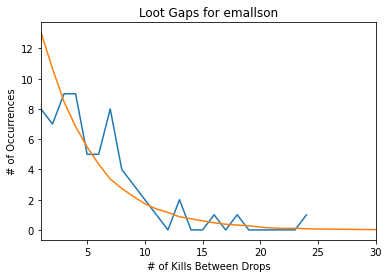

In [17]:
plot_loot_gaps(sl_data, me, lambda scale: plt.plot(np.bincount(np.random.geometric(4 / 20, scale * 1000)) / 1000))

In [18]:
bfa_raids = ['Uldir', 'Battle of Dazar\'alor', 'Ny\'alotha, the Waking City', 'The Eternal Palace']
bfa_difficulties = ['Normal', 'Heroic', 'Mythic']
bfa_keys = ['-'.join([r, d]) for r in bfa_raids for d in bfa_difficulties]

bfa_data = df[df.instance.isin(bfa_keys)]

['Cloth' 'Staves' 'Leather' 'Plate' 'Mail' 'Daggers' 'One-Handed Axes'
 'Shields' 'Fist Weapons' 'One-Handed Maces' 'Wands' 'One-Handed Swords'
 'Engineering' 'Guns' 'Warglaives' 'Two-Handed Axes' 'Polearms'
 'Two-Handed Maces' 'Crossbows' 'Two-Handed Swords' 'Bows']
BootstrapResult(confidence_interval=ConfidenceInterval(low=6.873949579831932, high=9.48045752052922), standard_error=0.6574268387369196)


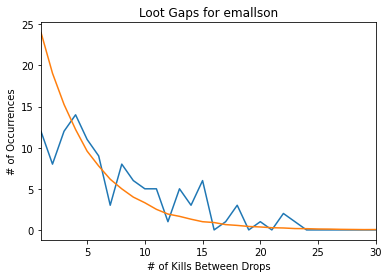

In [19]:
plot_loot_gaps(bfa_data, me, lambda scale: plt.plot(np.bincount(np.random.geometric(4 / 20, scale * 1000)) / 1000))

I think rather than inferring presence based on this I need to explicitly determine it from WCL data or somesuch.

In [35]:
sl_kills['unix'] = sl_kills['dt'].map(lambda dt: dt.timestamp() * 1000).astype('int64')

In [36]:
sl_kills[['unix', 'owner', 'instance', 'boss']]

unix                  owner                      instance  \
4969  1614974292000      Metasama-Turalyon         Castle Nathria-Mythic   
1060  1614974839000     Eisenpelz-Turalyon         Castle Nathria-Mythic   
4092  1615584738000     Eisenpelz-Turalyon         Castle Nathria-Mythic   
2637  1615584740000           Zæy-Turalyon         Castle Nathria-Mythic   
5803  1615584741000  Xraychickens-Turalyon         Castle Nathria-Mythic   
...             ...                    ...                           ...   
5011  1639341754000     Tendronas-Turalyon  Sanctum of Domination-Mythic   
6721  1639341916000      Mesprit-Mal'Ganis  Sanctum of Domination-Mythic   
142   1639342533000       Femaelz-Turalyon  Sanctum of Domination-Mythic   
145   1639349908000       Femaelz-Turalyon  Sanctum of Domination-Mythic   
7421  1639349921000      Jopdruid-Turalyon  Sanctum of Domination-Mythic   

                       boss  
4969  Stone Legion Generals  
1060  Stone Legion Generals  
4092  Stone Legion Generals  
2637  Stone Legion Generals  
5803  Stone Legion Generals  
...                     ...  
5011               The Nine  
6721               The Nine  
142     Remnant of Ner'zhul  
145        Painsmith Raznal  
7421       Painsmith Raznal  

[957 rows x 4 columns]